In [2]:
# import relevant libraries

import numpy as np
import copy
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras import regularizers
from keras import backend as K
import Data_prep as dp
from scipy.io import savemat, loadmat
from keras.losses import mse, binary_crossentropy
from keras.layers import Reshape, Lambda, Input, Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
K.set_image_data_format('channels_last')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# define sampler of SVE bottleneck layer

def sampling(input_param):
    """
    sampling the latent space from a Gaussian distribution:

    # Input
        input_param: mean and log of variance of q(z|x)

    # Output
        z: sampled latent space vector
    """
    
    #mean and log(var):
    z_mean, z_log_var = input_param 
    
    #dimensions:
    dim_1 = K.shape(z_mean)[0]
    dim_2 = K.int_shape(z_mean)[1]
    
    #sampling:
    norm_sample = K.random_normal(shape=(dim_1, dim_2))
    return z_mean + K.exp(0.5 * z_log_var) * norm_sample

In [4]:
#encoder network:

#regularization coefficient:
l_encode=0.001

#act. func. (hidden layers)
act='tanh'

#act. func. (output layers)
act_out='linear'

#input:
bathy_input = Input(shape=(41,501, 1), name = 'bathymetry')

#CNN/pooling layer 1&2:
x = Conv2D(8, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(bathy_input)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#CNN/pooling layer 3&4:
x = Conv2D(16, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#CNN/pooling layer 5&6:
x = Conv2D(32, (3, 3), strides=1, padding='same',kernel_regularizer = regularizers.l2(l_encode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#flattening:
shape = K.int_shape(x)
x = Flatten()(x)

#fully connected layer 1:
x = Dense(700,kernel_regularizer = regularizers.l2(l_encode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#output:
z_mean = Dense(50,activation=act_out,name='z_mean')(x)
z_log_var = Dense(50,activation=act_out,name='z_log_var')(x)
z = Lambda(sampling, output_shape=(50,), name='latent_encode')([z_mean, z_log_var])

#set encoder model:
encoder = Model(bathy_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 41, 501, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 41, 501, 8)   80          bathymetry[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 41, 501, 8)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 21, 251, 8)   0           activation_1[0][0]               
____________________________________________________________________________________________

In [5]:
encoder.trainable=True

In [6]:
#decoder network of v_x:

#regularization coefficient
l_decode=0.001

#input/BC:
BC_input = Input(shape=(2, ), name = 'BC') #BC
latent_input = Input(shape=(50,), name='latent_decode') #input
x = keras.layers.concatenate([latent_input, BC_input])

#fully connected layer 1:
x = Dense(700, kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#FC/CNN connection & reshaping:
x = Dense((5)*(62)*shape[3], kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)
x = Reshape((5, 62, shape[3]))(x)

#CNN/upsampling layer 1:
x = Conv2DTranspose(32, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 2:
x = Conv2DTranspose(16, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 3:
x = Conv2DTranspose(8, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#output:
outputs = Conv2DTranspose(1, (3, 3), activation=act_out, padding='same', name='velocity_x')(x)

#set decoder model:
decoder_vx = Model([latent_input,BC_input], outputs, name='decoder_vx')
decoder_vx.summary()

Model: "decoder_vx"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_decode (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 52)           0           latent_decode[0][0]              
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 700)          37100       concatenate_1[0][0]     

In [7]:
decoder_vx.trainable=True

In [8]:
#decoder network of v_y:

#regularization coefficient
l_decode=0.001

#input/BC:
BC_input = Input(shape=(2, ), name = 'BC') #BC
latent_input = Input(shape=(50,), name='latent_decode') #input
x = keras.layers.concatenate([latent_input, BC_input])

#fully connected layer 1:
x = Dense(700, kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#FC/CNN connection & reshaping:
x = Dense((5)*(62)*shape[3], kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)
x = Reshape((5, 62, shape[3]))(x)

#CNN/upsampling layer 1:
x = Conv2DTranspose(32, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 2:
x = Conv2DTranspose(16, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 3:
x = Conv2DTranspose(8, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#output:
outputs = Conv2DTranspose(1, (3, 3), activation=act_out, padding='same', name='velocity_y')(x)

#set decoder model:
decoder_vy = Model([latent_input,BC_input], outputs, name='decoder_vy')
decoder_vy.summary()

Model: "decoder_vy"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_decode (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 52)           0           latent_decode[0][0]              
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 700)          37100       concatenate_2[0][0]     

In [9]:
decoder_vy.trainable=True

In [10]:
#decoder network of Z (bathymetry):

#regularization coefficient
l_decode=0.001

#input/BC:
BC_input = Input(shape=(2, ), name = 'BC') #BC
latent_input = Input(shape=(50,), name='latent_decode') #input
x = keras.layers.concatenate([latent_input, BC_input])

#fully connected layer 1:
x = Dense(700, kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#FC/CNN connection & reshaping:
x = Dense((5)*(62)*shape[3], kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)
x = Reshape((5, 62, shape[3]))(x)

#CNN/upsampling layer 1:
x = Conv2DTranspose(32, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 2:
x = Conv2DTranspose(16, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#CNN/upsampling layer 3:
x = Conv2DTranspose(8, (3, 3), padding='same', kernel_regularizer = regularizers.l2(l_decode))(x)
#x = BatchNormalization(axis = 3)(x)
x = Activation(act)(x)
x = UpSampling2D((2, 2))(x)

#output:
outputs = Conv2DTranspose(1, (3, 3), activation=act_out, padding='same', name='velocity_Z')(x)

#set decoder model:
decoder_Z = Model([latent_input,BC_input], outputs, name='decoder_Z')
decoder_Z.summary()

Model: "decoder_Z"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_decode (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 52)           0           latent_decode[0][0]              
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 700)          37100       concatenate_3[0][0]      

In [11]:
decoder_Z.trainable=True

In [12]:
# set SVE model

outputs_vx = decoder_vx([encoder(bathy_input)[2],BC_input])
outputs_vy = decoder_vy([encoder(bathy_input)[2],BC_input])
outputs_Z = decoder_Z([encoder(bathy_input)[2],BC_input])
outputs= [outputs_vx,outputs_vy,outputs_Z]

vae = Model([bathy_input,BC_input], outputs, name='vae')
outputs[0].shape

TensorShape([None, None, None, 1])

In [13]:
#SVE loss function (can use loss='mse'+'KL divergence'):

def vae_loss(y_true, y_pred):
    sig_log=0
    mu=0
    xent_loss = 1*mse(K.flatten(y_true), K.flatten(y_pred))
    kl_loss=-0.5*K.mean(1+z_log_var-sig_log-K.square(z_mean-mu)/np.exp(sig_log)-K.exp(z_log_var)/np.exp(sig_log),axis=-1)    
    vae_loss = xent_loss +0.001*kl_loss
    return vae_loss

In [14]:
#compile SVE:

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001, amsgrad=False)

vae.compile(optimizer=opt, loss=vae_loss, metrics=['mse'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 41, 501, 1)   0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 50), (None,  8543888     bathymetry[0][0]                 
                                                                 bathymetry[0][0]                 
                                                                 bathymetry[0][0]                 
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
________________________________________________________________________________________________

In [15]:
#load/read train and validation data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6.mat')

vel0 = data['velocity_prof'] #velocities
z_f0 = data['z_f'] #free surface elevation
Q_b0 = data['Q_b'] #influx
Z0 = data['Z'] #bathymetry

#check data shape:
print(z_f0.shape)
print(Z0.shape)

(1, 4500)
(20541, 4500)


In [16]:
#load/read test data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6_test.mat')

vel1 = data['velocity_prof'] #velocities
z_f1 = data['z_f'] #free surface elevation
Q_b1 = data['Q_b'] #influx
Z1 = data['Z'] #bathymetry

#check data shape:
print(z_f1.shape)
print(Z1.shape)

(1, 450)
(20541, 450)


In [17]:
#join train/validation and test set

vel = np.concatenate((vel0,vel1),axis=1)
z_f = np.concatenate((z_f0,z_f1),axis=1)
Q_b = np.concatenate((Q_b0,Q_b1),axis=1)
Z = np.concatenate((Z0,Z1),axis=1)
vx, vy, _ = dp.xy_vel_sep(vel) #v_x/v_y separation

#check data shape:
print(vel.shape)
print(z_f.shape)
print(vx.shape)
print(Z.shape)

(41082, 4950)
(1, 4950)
(20541, 4950)
(20541, 4950)


In [18]:
#put bathymetry in right shape:

Z_dummy = Z.reshape(41,501,-1) 
Z_new = np.zeros((Z_dummy.shape[2],Z_dummy.shape[0],Z_dummy.shape[1])) 
for i in range(Z_dummy.shape[2]):
    Z_new[i,:,:] = Z_dummy[:,:,i]     
del Z_dummy

#check Z_new shape:
print(Z_new.shape)

(4950, 41, 501)


In [19]:
#put v_x in right shape:

vx_dummy = vx.reshape(41,501,-1)
vx_new = np.zeros((vx_dummy.shape[2],vx_dummy.shape[0],vx_dummy.shape[1]))
for i in range(vx_dummy.shape[2]):
    vx_new[i,:,:] = vx_dummy[:,:,i]
del vx_dummy

#check vx_new shape:
print(vx_new.shape)

(4950, 41, 501)


In [20]:
#put v_y in right shape: 

vy_dummy = vy.reshape(41,501,-1)
vy_new = np.zeros((vy_dummy.shape[2],vy_dummy.shape[0],vy_dummy.shape[1]))
for i in range(vy_dummy.shape[2]):
    vy_new[i,:,:] = vy_dummy[:,:,i]
del vy_dummy

#check vy_new shape:
print(vy_new.shape)

(4950, 41, 501)


In [21]:
#add channel dimension:

x_train = Z_new.reshape(-1,41,501,1) #input (Z)
y_train_x = vx_new.reshape(-1,41,501,1) #output (vx)
y_train_y = vy_new.reshape(-1,41,501,1) #output (vy)

#check shapes:
print(x_train.shape)
print(y_train_x.shape)

(4950, 41, 501, 1)
(4950, 41, 501, 1)


In [22]:
#find normalizing parameters:

N=4500 # number of data to be used (train+validation)

x_min = np.mean(x_train[:N,:,:,:], axis=0)
y_min_x = np.mean(y_train_x[:N,:,:,:], axis=0)
y_min_y = np.mean(y_train_y[:N,:,:,:], axis=0)

x_range = np.std(x_train[:N,:,:,:], axis=0)
x_range[x_range==0]=1

y_range_x = np.std(y_train_x[:N,:,:,:], axis=0)
y_range_x[y_range_x==0]=1

y_range_y = np.std(y_train_y[:N,:,:,:], axis=0)
y_range_y[y_range_y==0]=1

#check shapes:
print(x_min.shape)
print(y_min_x.shape)
print(x_range.shape)
print(y_range_x.shape)

(41, 501, 1)
(41, 501, 1)
(41, 501, 1)
(41, 501, 1)


In [23]:
#normalize input/outputs:

x_train_norm = (x_train-x_min)/x_range 
y_train_norm_x = (y_train_x-y_min_x)/y_range_x
y_train_norm_y = (y_train_y-y_min_y)/y_range_y

#check shapes:
print(x_train_norm.shape)
print(y_train_norm_x.shape)

#check min/max:
print(np.min(x_train_norm))
print(np.min(y_train_norm_x))
print(np.max(x_train_norm))
print(np.max(y_train_norm_x))

(4950, 41, 501, 1)
(4950, 41, 501, 1)
-4.711301465906763
-10.378835518374794
3.3733705633020246
10.965771092609335


In [24]:
#normalize BC (ensure it's between 0 and 1):

BC = np.zeros((2, z_f.shape[1]))
BC[0,:] = z_f/120
BC[1,:] = Q_b/30000

#check shapes and maxes:
print(BC.shape)
print(max(BC[0,:]))
print(max(BC[1,:]))

(2, 4950)
0.9531882083041187
0.9988410701086574


In [25]:
# data preparation:

#generate a seed number for reproducibility:
seed_num=np.random.randint(0,1e5) 
#seed_num=0 #use for reproducing a previously known seed #
print(seed_num)

#generate seed:
np.random.seed(seed_num)

M=0 #where the first index of data is
P=450 #size of test set
H=10 #number of BCs for each profile

#shuffle based on the seed:
indx=np.array(np.arange(0+M,x_train_norm[0:,:,:,:].shape[0]-P,H),dtype=int) #original indices (ascending) 
indx_new=copy.deepcopy(indx) #new (to be shuffled) indices
np.random.shuffle(indx_new) #shuffled idices

#create shuffled input/outputs:
x_train_norm_shfl=copy.deepcopy(x_train_norm[0:,:,:,:])
y_train_norm_shfl_x=copy.deepcopy(y_train_norm_x[0:,:,:,:])
y_train_norm_shfl_y=copy.deepcopy(y_train_norm_y[0:,:,:,:])
BC_shfl=copy.deepcopy(BC[:,0:])
for i in range(indx_new.shape[0]):
    x_train_norm_shfl[i*H+M:i*H+H+M,:,:,:]=x_train_norm[indx_new[i]:indx_new[i]+H,:,:,:]
    y_train_norm_shfl_x[i*H+M:i*H+H+M,:,:,:]=y_train_norm_x[indx_new[i]:indx_new[i]+H,:,:,:]
    y_train_norm_shfl_y[i*H+M:i*H+H+M,:,:,:]=y_train_norm_y[indx_new[i]:indx_new[i]+H,:,:,:]
    BC_shfl[:,i*H+M:i*H+H+M]=BC[:,indx_new[i]:indx_new[i]+H]

18616


In [26]:
#training:

val_split=0.1 #validation split (fraction of train/validation set to be used for validation)

#vae.load_weights('vae_f_Sav_BC_func_m4500_8_16_32_B_700_50_l0_001_0_001tantanlr0_001noB_vxvyZ_Z_vyT_vxT.h5') #to load saved weights, if necessary
vae.fit(x={'bathymetry':x_train_norm_shfl[:-P,:,:,:], 'BC':BC_shfl[:,:-P].T},
        y=[y_train_norm_shfl_x[:-P,:40,:496,:],y_train_norm_shfl_y[:-P,:40,:496,:],
           x_train_norm_shfl[:-P,:40,:496,:]],epochs=100,batch_size=32,shuffle=False,validation_split=val_split)
vae.save_weights('vae_f_Sav_BC_func_m4500_8_16_32_B_700_50_l0_001_0_001tantanlr0_001noB_vxvyZ_Z_vyT_vxT.h5') #to save optimized weights

In [27]:
#calculate SVE predictions (normalized):

z_mean_pred, z_log_pred, z_pred= encoder.predict(x_train_norm_shfl) #encoder output
y_decoded_pred_x = decoder_vx.predict([z_mean_pred,BC_shfl.T]) #decoder output v_x
y_decoded_pred_y = decoder_vy.predict([z_mean_pred,BC_shfl.T]) #decoder output v_y
y_decoded_pred_Z = decoder_Z.predict([z_mean_pred,BC_shfl.T]) #decoder output Z

#check shape:
print(y_decoded_pred_x.shape)

(4950, 40, 496, 1)


In [28]:
#calculate SVE predictions:

n=496
y_pred_x=y_decoded_pred_x*y_range_x[:40,:n,:]+y_min_x[:40,:n,:] #predicted output
y_pred_y=y_decoded_pred_y*y_range_y[:40,:n,:]+y_min_y[:40,:n,:] #predicted output
y_pred_Z=y_decoded_pred_Z*x_range[:40,:n,:]+x_min[:40,:n,:] #predicted output

#check shape:
print(y_pred_x.shape)

(4950, 40, 496, 1)


In [29]:
#rmse of train/test/validation for v_x:

y_true_x=y_train_norm_shfl_x[:,:40,:n]*y_range_x[:40,:n,:]+y_min_x[:40,:n,:]
print('train err v_x [ft/s]:',np.sqrt(np.mean((y_pred_x[:int(N-val_split*N),:,:]-y_true_x[:int(N-val_split*N),:40,:n])**2)))
print('test err v_x [ft/s]:',np.sqrt(np.mean((y_pred_x[int(N-val_split*N):N,:,:]-y_true_x[int(N-val_split*N):N,:40,:n])**2)))
print('validation err v_x [ft/s]:',np.sqrt(np.mean((y_pred_x[N:,:,:]-y_true_x[N:,:40,:n])**2)))

train err v_x [ft/s]: 0.1127950686097367
test err v_x [ft/s]: 0.11782598929897875
validation err v_x [ft/s]: 0.13086188234200244


In [30]:
#rmse of train/test/validation for v_y:

y_true_y=y_train_norm_shfl_y[:,:40,:n]*y_range_y[:40,:n,:]+y_min_y[:40,:n,:]
print('train err v_y [ft/s]:',np.sqrt(np.mean((y_pred_y[:int(N-val_split*N),:,:]-y_true_y[:int(N-val_split*N),:40,:n])**2)))
print('test err v_y [ft/s]:',np.sqrt(np.mean((y_pred_y[int(N-val_split*N):N,:,:]-y_true_y[int(N-val_split*N):N,:40,:n])**2)))
print('validation err v_y [ft/s]:',np.sqrt(np.mean((y_pred_y[N:,:,:]-y_true_y[N:,:40,:n])**2)))

train err v_y [ft/s]: 0.0826029932215535
test err v_y [ft/s]: 0.09235078612959324
validation err v_y [ft/s]: 0.09909476261351687


In [31]:
#rmse of train/test/validation for Z (bathymetry):

y_true_Z=x_train_norm_shfl[:,:40,:n]*x_range[:40,:n,:]+x_min[:40,:n,:]
print('train err Z [ft]:',np.sqrt(np.mean((y_pred_Z[:int(N-val_split*N),:,:]-y_true_Z[:int(N-val_split*N),:40,:n])**2)))
print('test err Z [ft]:',np.sqrt(np.mean((y_pred_Z[int(N-val_split*N):N,:,:]-y_true_Z[int(N-val_split*N):N,:40,:n])**2)))
print('validation err Z [ft]:',np.sqrt(np.mean((y_pred_Z[N:,:,:]-y_true_Z[N:,:40,:n])**2)))

train err Z [ft]: 0.8200800355286811
test err Z [ft]: 0.8003441821530514
validation err Z [ft]: 1.0494087700998203


In [32]:
# plot preparation (v_x); can be done similarly for v_y and Z

N=4950
x_pred_sparse_x=np.zeros((N,41, 501))
x_pred_sparse_x[:,:40,:496]=y_pred_x[:,:40,:496].squeeze()
x_pred_sparse_x[:, 40,:]=x_pred_sparse_x[:, 38,:]
x_pred_sparse_x[:, 39,:]=x_pred_sparse_x[:, 38,:]
x_pred_sparse_x[:, :,495]=x_pred_sparse_x[:, :,494]
x_pred_sparse_x[:, :,496]=x_pred_sparse_x[:, :,494]
x_pred_sparse_x[:, :,497]=x_pred_sparse_x[:, :,494]
x_pred_sparse_x[:, :,498]=x_pred_sparse_x[:, :,494]
x_pred_sparse_x[:, :,499]=x_pred_sparse_x[:, :,494]
x_pred_sparse_x[:, :,500]=x_pred_sparse_x[:, :,494]
y_pred_sparse_x=np.zeros((N,41, 501))
y_pred_sparse_x[:,:40,:496]=y_true_x[:,:40,:496].squeeze()
y_pred_sparse_x[:, 40,:]=y_pred_sparse_x[:, 38,:]
y_pred_sparse_x[:, 39,:]=y_pred_sparse_x[:, 38,:]
y_pred_sparse_x[:, :,495]=y_pred_sparse_x[:, :,494]
y_pred_sparse_x[:, :,496]=y_pred_sparse_x[:, :,494]
y_pred_sparse_x[:, :,497]=y_pred_sparse_x[:, :,494]
y_pred_sparse_x[:, :,498]=y_pred_sparse_x[:, :,494]
y_pred_sparse_x[:, :,499]=y_pred_sparse_x[:, :,494]
y_pred_sparse_x[:, :,500]=y_pred_sparse_x[:, :,494]

In [ ]:
ind=60 #data point index to plot its true vs estimated v_x (or v_y, or Z)

dp.plt_im_tri(depth=y_pred_sparse_x[ind, :,:].ravel(), fig_title= 'reference', fig_name='ref_v_x.png',vmin_=0, vmax_=0.5)
dp.plt_im_tri(depth=(x_pred_sparse_x[ind, :,:]).ravel(), fig_title= 'SVE prediction (dim=50)', fig_name='SVE_v_x.png',vmin_=0, vmax_=0.5)

In [62]:
# import relevant libraries for inversion (MAP estimator)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

from scipy.sparse.linalg import LinearOperator, cg
import scipy.optimize as opt

In [64]:
# import relevant parameters for inversion (based on trained and saved ROM parameters)

scale_param = np.load('scale_sve_const.npy')
scale_smin = scale_param[:,:,0]
scale_srange = scale_param[:,:,1]
scale_vxmin = scale_param[:,:,2]
scale_vxrange = scale_param[:,:,3]
scale_vymin = scale_param[:,:,4]
scale_vyrange = scale_param[:,:,5]

scale_smin=x_min.squeeze()
scale_srange=x_range.squeeze()
scale_vxmin=y_min_x.squeeze()
scale_vxrange=y_range_x.squeeze()
scale_vymin=y_min_y.squeeze()
scale_vyrange=y_range_y.squeeze()
print(scale_smin.shape)

# due to CNN architecture (maxpooling)
scale_vxmin = scale_vxmin[:40,:496]
scale_vxrange = scale_vxrange[:40,:496]
 
scale_vymin = scale_vymin[:40,:496]
scale_vyrange = scale_vyrange[:40,:496]
 
scale_BCrange = np.zeros((2,1))
scale_BCrange[0] = 120.
scale_BCrange[1] = 30000.

(41, 501)


In [65]:
# import relevant plotting files

mesh=loadmat("mesh.mat")
triangles = mesh['triangles'] #'triangles.txt'
meshnode   = mesh['meshnode'] #'meshnode.txt'
x0=0
xf=40
y0=0
yf=496
dx=1
dy=1

In [67]:
# import relevant parameters for inversion (based on trained and saved ROM parameters)

nx, ny = 501, 41
BC_scaled = np.loadtxt('BC_true3.txt').reshape(2,1) # thoses values already scaled.
print(BC_scaled)
s_true = np.loadtxt('true3.txt')
obsx = np.loadtxt('obs3_vx.txt')
obsy = np.loadtxt('obs3_vy.txt')
print(obsx.reshape(40,496)[x0:xf:dx,y0:yf:dy].reshape(-1).shape)
obsx=obsx.reshape(40,496)[x0:xf:dx,y0:yf:dy].reshape(-1)
obsy=obsy.reshape(40,496)[x0:xf:dx,y0:yf:dy].reshape(-1)
obs = np.hstack([obsx.reshape(-1),obsy.reshape(-1)]).reshape(-1,1)

obs = obs + 0.05*np.random.randn(obs.shape[0],obs.shape[1])
print(obs.shape)

[[0.84104558]
 [0.25572422]]
(19840,)
(39680, 1)


In [69]:
# dimensions 

m = 50 # latent_dim
nobs = obs.shape[0] # # of obs.
print(obs.shape)

(39680, 1)


In [70]:
# prior mean (and intial guess)

# prior covariance
Sigma = 1.0**2
z_init = np.random.randn(m,1)

In [71]:
# machine precision for finite difference

precision = np.finfo(np.float32).eps # for optimal FD delta

print(precision)

1.1920929e-07


In [72]:
# error matrix (assuming known)

R = 2.0**2
invR = 1./R

In [74]:
itermax = 10

# tol = define... #another stopping criteria

In [75]:
# forward map function (from latent space, z, to v_x and v_y)

def forward(z):
    #  from z to simulated velocity

    vx = decoder_vx.predict([z.T,BC_ind.T])
    vy = decoder_vy.predict([z.T,BC_ind.T])
    simul_obs_vx = (np.multiply(vx.reshape(40,496),scale_vxrange) + scale_vxmin)[x0:xf:dx,y0:yf:dy]
    simul_obs_vy = (np.multiply(vy.reshape(40,496),scale_vyrange) + scale_vymin)[x0:xf:dx,y0:yf:dy]

    simul_obs_vx = simul_obs_vx.reshape(-1)
    simul_obs_vy = simul_obs_vy.reshape(-1)
    simul_obs = np.hstack((simul_obs_vx,simul_obs_vy))
    
    return simul_obs.reshape(-1,1)

In [85]:
# encoder function

def nonlinear_forward_model(s):
    # s to simulated velocity

    s2d_scaled = (s.reshape(ny,nx) - scale_smin)/scale_srange
    z, _, _ = encoder.predict(s2d_scaled.reshape(1,ny,nx,1)) #encoder output

    simul_obs = forward(z.T)
    return simul_obs

In [84]:
# rmse calculation function

def rmse(z):
    # compute rmse between obs. and simulated velocity
   
    res = np.hstack((y_pred_x[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2),
                     y_pred_y[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2))).reshape(-1,1) - forward(z)
   
    return np.sqrt(np.sum(res**2)/nobs)

In [83]:
# optimization objective function (MAP estimator)

def obj_func(z):
    # objective function value to be minimized
    
    res = np.hstack((y_pred_x[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2),
                     y_pred_y[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2))).reshape(-1,1) - forward(z)
    zvec = z.reshape(-1,1)
  
    return (np.dot(res.T,np.dot(invR,res)) + Sigma*np.dot(zvec.T,zvec)).reshape(-1)

In [79]:
# line search

def obj_func_linesearch(alpha,*args):
    # simple line search - it is not optimal but the forward model is not expensive. 
    
    x0 = args[0]
    direction = args[1]
    return obj_func((1-alpha)*x0+alpha*direction)

In [80]:
# encoding s (bathymetry) to z (latent space)

def s_to_z(s):
    # encoding s to z 
    
    s2d_scaled = (s.reshape(ny,nx) - scale_smin)/scale_srange
    z, _, _ = encoder.predict(s2d_scaled.reshape(1,ny,nx,1)) #encoder_vx output
  
    return z

In [81]:
# decoding z (latent space) to s (bathymetry)

def z_to_s(z):
    # decoding z to s
    
    s = decoder_Z.predict([z.T,BC_ind.T])
  
    s_pred = np.zeros((ny,nx))
    s_pred[:40,:496] = s.reshape(40,496)*scale_srange[:40,:496] + scale_smin[:40,:496]
    s_pred[40,:] = s_pred[39,:]
    s_pred[:,496:] = s_pred[:,495:496]

    return s_pred

In [90]:
# MAP estimation iteration:

import time
from scipy.sparse.linalg import LinearOperator, cg
import scipy.optimize as opt

ind_s=0 #index in test set (or index of the first data point in a set when using MAP for multiple data points)
shft=4500+ind_s #shift the data index to account for the first 4500 data points (train + validation sets) 

S_true=np.zeros((1,41,501)) # true bathymetries
S_est=np.zeros((1,41,501)) #estimated bathymetries

for ind in range(0,1): # can be other than 1 to estimate MAP for multiple data points (see comment on ind_s)
    print(ind)
    s_true=x_train_norm_shfl[ind+shft,:,:]*x_range+x_min
    S_true[ind,:,:]=s_true.reshape(1,41,501)
    z_true = s_to_z(s_true)
    BC_ind=BC_shfl[:,shft+ind:shft+ind+1]
    obj_func(z_init)
    z_cur = np.copy(z_init)

    obs=np.hstack((y_pred_x[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2),
                   y_pred_y[ind+shft,x0:xf:dx,y0:yf:dy].reshape(-1,obs.shape[0]//2))).reshape(-1,1)+0.05*np.random.randn(obs.shape[0],obs.shape[1])

    t = time.time()

    print('objective, RMSE and zRMSE at z_init: %e, %e, %e' % (obj_func(z_init),rmse(z_init), np.sqrt(np.sum(((z_cur-z_true)**2)/m))))
    for i in range(itermax):
        J_cur = np.zeros((nobs,m))
        forward_z_cur = forward(z_cur)
        print('(1) iter %d evaluate Jacobian using FD' % i)
        for j in range(m):
            zerovec = np.zeros((m,1))
            zerovec[j] = 1.

    # following PCGA delta calculation (also see Brown and Saad, 1990)
            mag = np.dot(z_cur.T,zerovec)
            absmag = np.dot(abs(z_cur.T),abs(zerovec))
            if mag >= 0:
                signmag = 1.
            else:
                signmag = -1.
    
            delta = signmag*np.sqrt(precision)*(max(abs(mag),absmag))/((np.linalg.norm(zerovec)+ np.finfo(float).eps)**2)
            if delta == 0:
                delta = np.sqrt(precision)

            J_cur[:,j:j+1] = (forward(z_cur+zerovec*delta) - forward_z_cur)/delta
 
        print('(2) Compute inverse solution' )  
        Jz_cur = np.dot(J_cur,z_cur)

        def mv(v):
            return Sigma*np.dot(J_cur,np.dot(J_cur.T,v)) + R*v

        Cauto = LinearOperator((nobs, nobs), matvec=mv)
        x_tmp, ret = cg(Cauto, obs - forward_z_cur + Jz_cur)
        if ret != 0:
            print(ret)
        dz = Sigma*np.dot(J_cur.T, x_tmp.reshape(-1,1))  
  
        print('(3) line search' )  
        res = opt.minimize_scalar(fun=obj_func_linesearch,args=(z_cur,dz))
        alpha = res.x
        print('alpha',alpha)
        # update (need linear search)
        z_cur = np.copy((1-alpha)*z_cur + alpha*dz)
  
        print('objective, RMSE and zRMSE at iter %d: %e, %e, %e' % (i+1,obj_func(z_cur), rmse(z_cur), np.sqrt(np.sum(((z_cur-z_true)**2)/m))))
        if np.abs(alpha) < 1.e-2: #was 2
            z_est = z_cur
            break

        z_est = z_cur

    elapsed = time.time() - t
    print('Inversion time: %f seconds' % (elapsed))

    s_est = z_to_s(z_est)
    S_est[ind,:]=s_est

    simul_obs_s_est = nonlinear_forward_model(s_est)
    
S_true_all=S_true
S_est_all=S_est

0
objective, RMSE and zRMSE at z_init: 1.836406e+03, 4.230771e-01, 1.003961e+01
(1) iter 0 evaluate Jacobian using FD
(2) Compute inverse solution
(3) line search
alpha [0.97249341]
objective, RMSE and zRMSE at iter 1: 3.872145e+01, 3.019408e-02, 8.355942e+00
(1) iter 1 evaluate Jacobian using FD
(2) Compute inverse solution
(3) line search
alpha [0.98329]
objective, RMSE and zRMSE at iter 2: 3.507433e+01, 1.977130e-02, 8.447167e+00
(1) iter 2 evaluate Jacobian using FD
(2) Compute inverse solution
(3) line search
alpha [0.03260684]
objective, RMSE and zRMSE at iter 3: 3.507428e+01, 1.977809e-02, 8.447016e+00
(1) iter 3 evaluate Jacobian using FD
(2) Compute inverse solution
(3) line search
alpha [0.31770166]
objective, RMSE and zRMSE at iter 4: 3.507067e+01, 1.985654e-02, 8.444667e+00
(1) iter 4 evaluate Jacobian using FD
(2) Compute inverse solution
(3) line search
alpha [1.18359692]
objective, RMSE and zRMSE at iter 5: 3.506455e+01, 1.977735e-02, 8.445761e+00
(1) iter 5 evaluate Jac

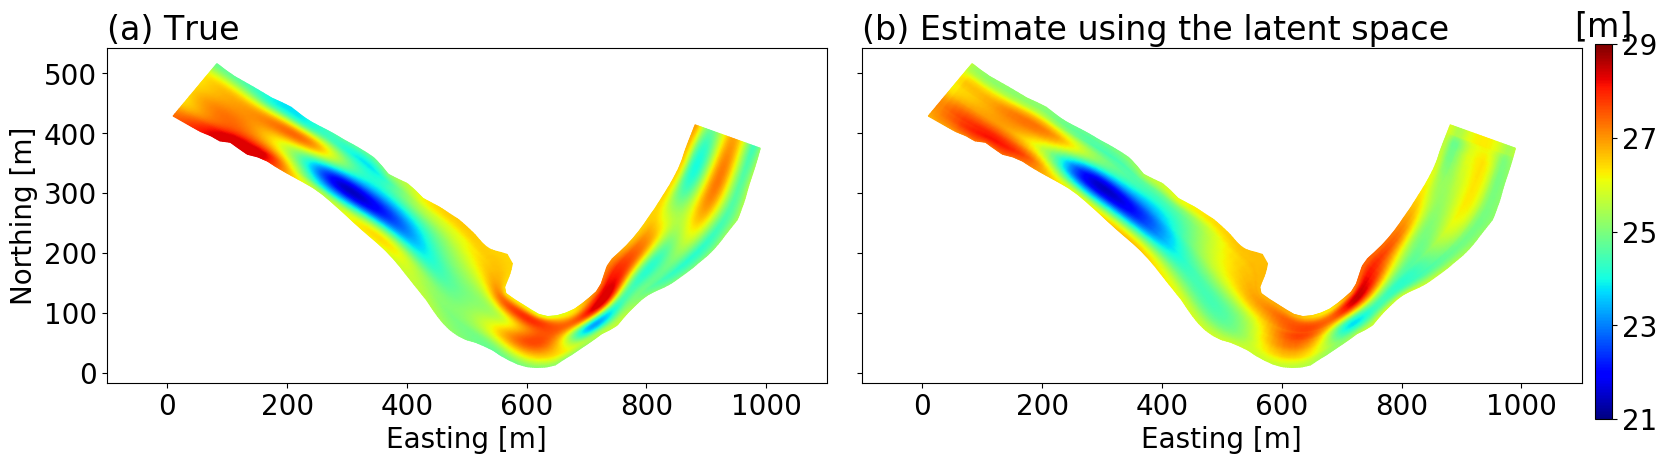

In [91]:
# plot MAP estimation vs true bathymetry

id=0 #index to plot (index among the data set picked above; if there is only one MAP estimation, then id=0)

mesh=loadmat("mesh.mat")
triangles = mesh['triangles']
meshnode   = mesh['meshnode']
# plot centered (0,0) in meter
ft_to_m = 0.3010
offsetx = 220793.
offsety = 364110.

fig, axes = plt.subplots(1,2, sharey = True, figsize=(17.,5.),dpi = 100)

im1=axes[0].tripcolor(meshnode[:,0]*ft_to_m-offsetx,meshnode[:,1]*ft_to_m-offsety,triangles, S_true_all[id,:].reshape(-1)*ft_to_m,shading='gouraud', cmap=plt.get_cmap('jet'),vmin=21.0,vmax=29.0)
axes[0].set_title('(a) True', loc='left')
axes[0].set_ylabel("Northing [m]")
axes[0].set_xlabel("Easting [m]")
axes[0].axis('equal')
#axes[0].set_xticks([])
#axes[0].set_yticks([])
axes[1].tripcolor(meshnode[:,0]*ft_to_m-offsetx,meshnode[:,1]*ft_to_m-offsety,triangles,S_est_all[id,:].reshape(-1)*ft_to_m,shading='gouraud', cmap=plt.get_cmap('jet'),vmin=21.0,vmax=29.0)
axes[1].set_title('(b) Estimate using the latent space', loc='left')
axes[1].axis('equal')
axes[1].set_xlabel("Easting [m]")
#axes[1].set_xticks([])
#axes[1].set_yticks([])

cax1 = fig.add_axes([0.95,0.13,0.01,0.75]) # 30pts
cbar1 = fig.colorbar(im1, cax=cax1, orientation='vertical',ticks=[21,23,25,27,29])
cbar1.ax.set_xticklabels(['21', '23','25', '27','29'])# horizontal colorbar
cbar1.ax.set_title('[m]')

plt.tight_layout(rect=[0.0,0.0,0.96,1.0])

In [92]:
# calculate covariance matrix

invQ = np.eye(m) + np.dot(J_cur.T, J_cur) 

In [93]:
# perform eigen-decomposition of Q-inverse

w,v=np.linalg.eig(invQ)
 
idx = w.argsort() # decreasing order for inversion
invS = w[idx]
U = v[:,idx]

-0.111199416 0.900485
-0.09131711639150372 0.7844419943293752


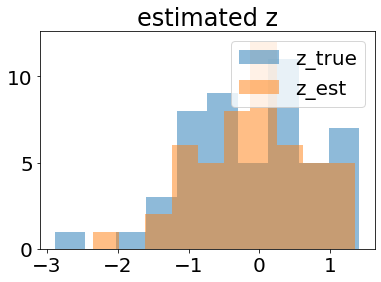

In [94]:
# latent space plot (estimated vs true)

plt.figure()
plt.hist(z_true.T,10, alpha=0.5, label = 'z_true')
plt.hist(z_est,10, alpha=0.5, label ='z_est')
plt.legend(loc='upper right')
plt.title('estimated z')
print(np.mean(z_true), np.std(z_true))
print(np.mean(z_est),np.std(z_est))
plt.show()

-0.111199416 0.900485
-0.09131711639150372 0.7844419943293752


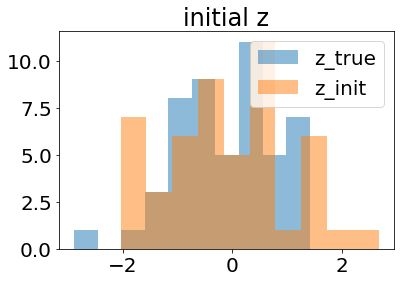

In [95]:
# latent space plot (initial vs true)

plt.figure()
plt.hist(z_true.T,10, alpha=0.5, label = 'z_true')
plt.hist(z_init,10, alpha=0.5, label ='z_init')
plt.legend(loc='upper right')
plt.title('initial z')
print(np.mean(z_true), np.std(z_true))
print(np.mean(z_est),np.std(z_est))

Text(0.5, 1.0, 'Eigenspectrum of $Q_{post,z}$')

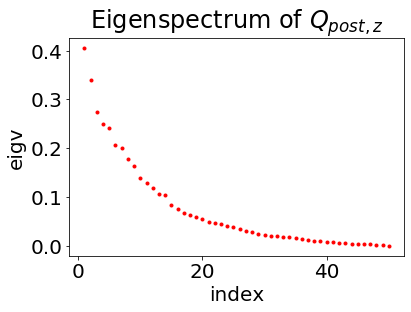

In [96]:
# eigen-spectrum plot

fig=plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.r_[1:m+1:],1./invS,'.', color='red')

plt.xlabel('index')
plt.ylabel('eigv')

plt.title(r'Eigenspectrum of $Q_{post,z}$')